# Deployment: Model Definition

Introduction.

## Dataset: Iris

The Iris dataset consits of the values of 4 features of 3 related flower species.

The course by J.M. Protilla provides a CSV already.

Another way of loading the dataset is with Scikit-Learn:

```python
from sklearn.datasets import load_iris
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']
```

In [1]:
import numpy as np
import pandas as pd

In [12]:
iris = pd.read_csv('../../data/iris.csv')

In [13]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [23]:
# Take features
X = iris.drop('species',axis=1)

In [15]:
# Take tagerts
y = iris['species']

In [16]:
y.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [24]:
# Create one-hot encodings
y = pd.get_dummies(iris['species'],drop_first=False)

In [27]:
# Another option for 
from sklearn.preprocessing import LabelBinarizer

In [28]:
encoder = LabelBinarizer()

In [29]:
y = iris['species']
y = encoder.fit_transform(y)

In [32]:
# Train/Test split
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [39]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

In [40]:
scaler = MinMaxScaler()

In [41]:
scaler.fit(X_train)

MinMaxScaler()

In [43]:
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Model

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [60]:
model = Sequential()
model.add(Dense(units=4,activation='relu',input_shape=[4,]))
model.add(Dense(units=3,activation='softmax'))

In [61]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [62]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
early_stop = EarlyStopping(patience=10)

In [64]:
model.fit(x=scaled_X_train,
          y=y_train,
          epochs=1000,
          validation_data=(scaled_X_test,y_test),
          callbacks=[early_stop],
          verbose=0)

In [67]:
metrics = pd.DataFrame(model.history.history)

<AxesSubplot:>

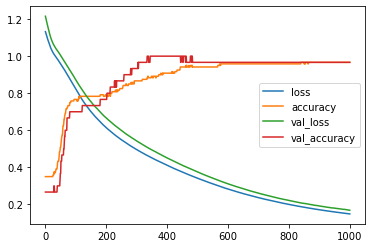

In [68]:
metrics.plot()

In [70]:
# Evaluate: final loss & accuracy on the test split
model.evaluate(scaled_X_test,y_test,verbose=0)

[0.16841982305049896, 0.96666664]

## Preparation for Deployment

When we consider that our test split has enough accuracy, we perform the following steps:
1. We re-define our model as before and train it with the complete dataset and without in-training validation the number of epochs we obtained with early stopping; this way, the model is supposed to be better trained...
2. We save our model as `*.h5` and everything we have used to transform the data too, e.g. the `scaler()`.

In [71]:
scaler = MinMaxScaler()

In [73]:
# Complete dataset scaled
scaled_X = scaler.fit_transform(X)

In [81]:
# Re-definition of the same model as before
model = Sequential()
model.add(Dense(units=4,activation='relu',input_shape=[4,]))
model.add(Dense(units=3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [82]:
# Train the model with the complete dataset
# We do it without early stopping and until the epoch until it trained before
model.fit(x=scaled_X,
          y=y,
          epochs=1000,
          verbose=0)

In [86]:
# The apparent accuracy should be better, now
# but it is nit real; the real accuracy is the one we had before
model.evaluate(scaled_X,y,verbose=0)

[0.07890055030584335, 0.96]

In [87]:
# Save our model
model.save('final_iris_model.h5')

In [90]:
# Save the scaler or any transformer that processes the data
# Joblib comes with python: it saves any python object to disk
# We use it to serialize the scaler to a *.pkl (pickle) file
import joblib

In [89]:
joblib.dump(scaler,'iris_scaler.pkl')

['iris_scaler.pkl']

In [91]:
# Check that we can load everything

In [92]:
from tensorflow.keras.models import load_model

In [93]:
flower_model = load_model('final_iris_model.h5')

In [94]:
flower_scaler = joblib.load('iris_scaler.pkl')

## Deployment Data Exchange: JSON / Dictionaries

We often exchange JSON objects between the user/client and our deployed moddel. Those JSON objects typically contain (1) the sample(s) with the features we want to feed to the model and (2) the result of the inference.

JSON objects are usually mapped to dictionaries in python.

In [96]:
iris.head(1)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa


In [109]:
# We create a dictionary with artificial data
flower_example = {"sepal_length":5.4,
                  "sepal_width":3.3,
                  "petal_length":1.2,
                  "petal_width":0.15}

## Inference Function

In [111]:
# We create a function that takes:
# - a trained model
# - all necessary transformation objects
# - a dict/json with a new sample
# and returns the prediction/inference
def return_prediction(model,scaler,sample_json):
    # Extract relevant values
    s_len = sample_json["sepal_length"]
    s_wid = sample_json["sepal_width"]
    p_len = sample_json["petal_length"]
    p_wid = sample_json["petal_width"]
    # Pack values into an array
    flower = [[s_len,s_wid,p_len,p_wid]]
    # Scale array
    flower = scaler.transform(flower)
    # Inference
    # We get an array with class id, so we grab first element
    # We can check that manually
    class_ind = model.predict_classes(flower)[0]
    classes = np.array(['setosa', 'versicolor', 'virginica'])
    # Return class value
    return classes[class_ind]

In [108]:
return_prediction(flower_model,flower_scaler,flower_example)

/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


'setosa'

## CODE FOR DEPLOYMENT

**IMPORTANT: We copy & past / prepare from our notebook the code we are going to use in the deployment.** Obviously, notebooks are great for development and testing, but we need to transform them into more deployable files. It is a good practice to write down all the lines necessary for a deployment at the end of the notebook.

In [112]:
from tensorflow.keras.models import load_model
import numpy as np
import joblib

flower_model = load_model('final_iris_model.h5')
flower_scaler = joblib.load('iris_scaler.pkl')

def return_prediction(model,scaler,sample_json):
    # Extract relevant values
    s_len = sample_json["sepal_length"]
    s_wid = sample_json["sepal_width"]
    p_len = sample_json["petal_length"]
    p_wid = sample_json["petal_width"]
    # Pack values into an array
    flower = [[s_len,s_wid,p_len,p_wid]]
    # Scale array
    flower = scaler.transform(flower)
    # Inference
    # We get an array with class id, so we grab first element
    # We can check that manually
    class_ind = model.predict_classes(flower)[0]
    classes = np.array(['setosa', 'versicolor', 'virginica'])
    # Return class value
    return classes[class_ind]